(hgf_exercises)=
# Hierarchical Gaussian Filter modelling exercises

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [21]:
from pyhgf import load_data
from pyhgf.model import HGF
import pandas as pd
import jax.numpy as jnp
import arviz as az

# load example dataset
timeseries = load_data("continuous")

In this notebook you are going to learn the core principles on which the HGF is built, you will build agents that can filter new observations and update their beliefs about hidden states of the world and try to optimize them so they are getting less and less surprised about what is happening. Finally, you will create an agent that tries to optimize its behaviour when facing (almost) unpredictable events.

## Theory: Modeling belief updating under uncertainty
### Gaussian random walks

The generative model on which the HGF is built is a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the variance of the distribution. 

```{admonition} Exercise 1
Using the equation above, write a Python code that implements a Gaussian random walk using the following parameters: $\sigma^2 = 1$ and $x_1^{(0)} = 0$.
```

### Volatility coupling

The HGF hierarchically generalize the GRW by making the parameters of a stochastic process depend on another GRW at a higher level. This kind of dependency is termed "coupling" and can target the volatility ($\sigma^2$) or the value ($\mu$), or both. 

If we take as an example the two-level continuous HGF {cite:p}`2014:mathys`, the model is constituted of two states of interest, $x_1$ and $x_2$. The node $x_1$ is performing a GRW, but it is also paired with $x_2$ via *volatility coupling*. This means that for state $x_1$, the mean of the Gaussian random walk on time point $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(x_2^{(k)} + \omega_1)
$$

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \exp(\omega_2))
$$

```{admonition} Exercise 2
Using the equation above and your previous implementation, write a Python code that implements a hierarchical Gaussian random walk with the following parameters: $\omega_1 = -6.0$, $\omega_2 = -6.0$, $\mu_1 = 0.0$, $\mu_2 = -2.0$, $x_{1} = 0.0$ and $x_{2} = -2.0$

What happens if you try different values of $\omega$?
```

### The continuous HGF

The pyhgf package implements this process with the corresponding update equation so the model can take as input a time series and infer the more likely generative structure that created the values. This can be extremely useful if you want to work with time series that have varying levels of volatility (i.e. meta-volatility). In the following example, we illustrate how we can use the Hierarchical Gaussian Filter to filter and predict inputs in a continuous node.

In [22]:
# create a sime two-levels continuous HGF with defaults parameters
two_levels_continuous_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 0.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -8.0, "2": -1.0},
)

Creating a continuous Hierarchical Gaussian Filter with 2 levels.


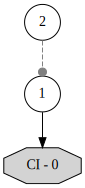

In [23]:
two_levels_continuous_hgf.plot_network()

In [24]:
# add new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeseries)

Add 614 new continuous observations.


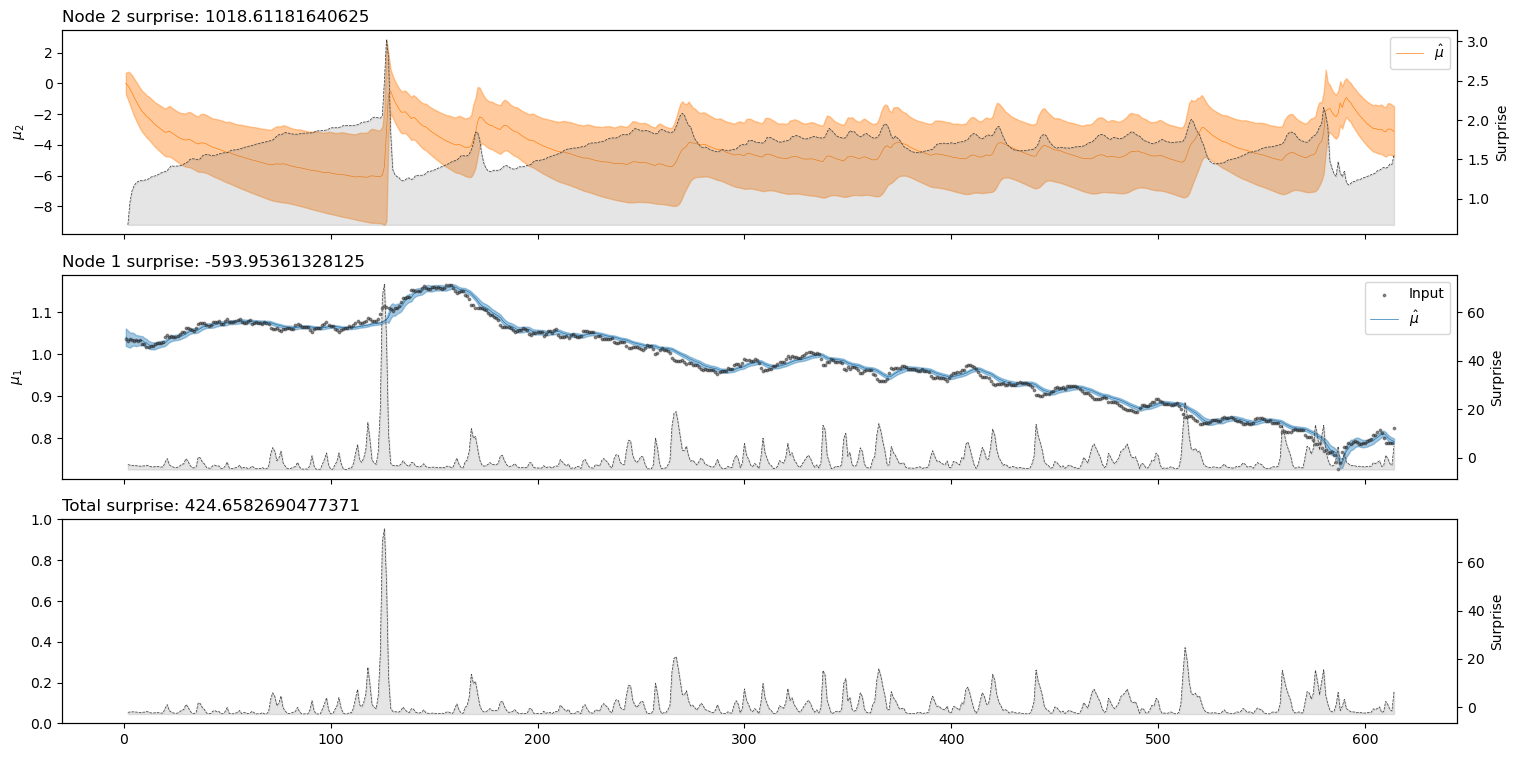

In [25]:
two_levels_continuous_hgf.plot_trajectories();

In [7]:
two_levels_continuous_hgf.surprise()

Array(-593.9536, dtype=float32)

```{admonition} Exercise 3
$\omega$ represents the tonic part of the variance (the part that is not affected by the parent node). Using the code example above, create another model with different values for $\omega$ at the second level. What is the consequence of changing this value on the beliefs trajectories? What is the "best" model in this context?
```

### Parameters optimization

So far we have been running the HGF forward by fixing the values of the parameters beforehand. We can also adopt an alternative approach and try to estimate the most likely value of a given parameter from an input time series (i.e. what would be the "best" agent in this context?). This can be done through Bayesian inference. Here we are going to use Hamiltonian Monte Carlo sampling using PyMC.

In [26]:
import pymc as pm
import numpy as np
from pyhgf.distribution import HGFDistribution
from pyhgf.response import first_level_gaussian_surprise

hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=[timeseries],
    response_function=first_level_gaussian_surprise
)

In [27]:
with pm.Model() as two_level_hgf:

    # omegas priors
    omega_1 = pm.Uniform("omega_1", -20, -2.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-2.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=timeseries[0],
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=np.nan,
            rho_3=np.nan,
            pi_3=np.nan,
            mu_3=np.nan,
            kappa_2=np.nan
        ),
    )

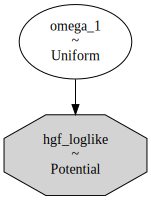

In [28]:
pm.model_to_graphviz(two_level_hgf)

In [31]:
with two_level_hgf:
    idata = pm.sample(chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [omega_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


array([[<AxesSubplot:title={'center':'omega_1'}>,
        <AxesSubplot:title={'center':'omega_1'}>]], dtype=object)

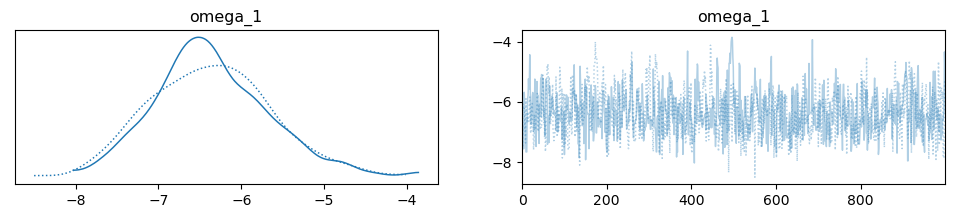

In [32]:
az.plot_trace(idata)

In [33]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1,-6.359,0.71,-7.752,-5.123,0.028,0.019,704.0,561.0,1.0


## Practice: Filtering the worlds weather to optimize behavior

In the previous section, we introduced the basic computational concept behind the Hierarchical Gaussian Filter and illustrated:

1. How to fit the HGF to a time series.
2. How to find the parameters that optimize a simple response function.

In this section, we are going to apply this knowledge to more practical considerations and try to build agents that can optimize their behaviour under volatile sensory inputs. We will take the example of agents that experiences fluctuation in the weather and would like to optimize their behaviour (e.g. regarding whether or not they should carry an umbrella for the next day). Experiencing rain while not having an umbrella is extremely annoying for these agents (this elicits a lot of surprises), but carrying an umbrella in sunny weather is also annoying. You should therefore come up with a solution to help them optimise their decisions. For the exercise we will consider that the agents cannot just look by the windows and check the weather, they have to decide at least one day for the next or more, using their current understanding of the weather (i.e. their beliefs about the latent variables in the environment).

We will use data from {citep}`pfenninger:2016, staffell:2016` that is made available at the following database: https://renewables.ninja/. This database contains hourly recordings of various weather parameters that have been tracked over one year at a different positions in the world. You can explore the database and use the recording you like, you can also compare agents trained in different part of the globe. The procedure is the following: 
1. Set the point or search for a location
2. Extend the weather button and check all boxes (if you wish to use the premade processing script) or select your data structure.
3. Press "run" and wait for the simulation to run
4. Save hourly output as CSV

Alternatively, we provide here a data frame that can be easily loaded, it contains the weather parameters recorded in Aarhus:

In [34]:
aarhus_weather_df = pd.read_csv("https://raw.githubusercontent.com/ilabcode/hgf-data/main/datasets/weather.csv")
aarhus_weather_df.head()

,time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
0,2019-01-01 00:00,7.387,0.124,0.0,0.0,1.249,0.0,0.0,0.931
1,2019-01-01 01:00,7.472,0.200,0.0,0.0,1.247,0.0,0.0,0.865
2,2019-01-01 02:00,7.635,0.196,0.0,0.0,1.244,0.0,0.0,0.701
3,2019-01-01 03:00,7.224,0.061,0.0,0.0,1.245,0.0,0.0,0.387
4,2019-01-01 04:00,6.147,0.018,0.0,0.0,1.250,0.0,0.0,0.128


The data frame contains the following parameters, recorded every hour over the year of 2019:

- t2m: the 2-meter above ground level air temperature
- prectotland : The rain precipitation rate (mm/hour)
- precsnoland : Snow precipitation rate (mm/hour)
- snomas : Total snow storage land (kg/m2)
- rhoa : Air density at surface (kg/m3)
- swgdn : Surface incoming shortwave flux (W/m2) (considering cloud cover) (The value at the surface is approximately 1000 W/m2 on a clear day at solar noon in the summer months) 
- swtdn : Toa (top of atmosphere) incoming shortwave flux (W/m2)
- cldtot : Total cloud area fraction. An average over grid cells and summed over all height above ground ([0,1] scale where 0 is no cloud and 1 is very cloudy)

```{admonition} Exercises 4
- Select a city and download a recording OR use the data frame loaded above.
- Choose which weather variables to work with.
- Set up an HGF structure and run it forward on the data.
- Set up an agent who has to decide something based on the weather (to carry an umbrella, or how many layers of clothes they have to put on based on temperature, cloudiness etc. ) and incorporate meaningful HGF parameters in the model.
- Compare the performances of two agents and interpret their differences. You have to choose what makes the two agents different: they can be trained on different data (e.g. from different cities, from different months...), have different HGF parameters, have different number of level, have different response functions (e.g. one agent can have pleasure carrying an umbrella when it is raining)... You can decide to optimize the parameters or not, this also depends on your hypothesis.
```

To illustrate on possible workflow, we create an agent that tries to use the temperature to decide for taking an umbrella the next day. We use the first month of recording to train the agent:

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
Add 720 new continuous observations.


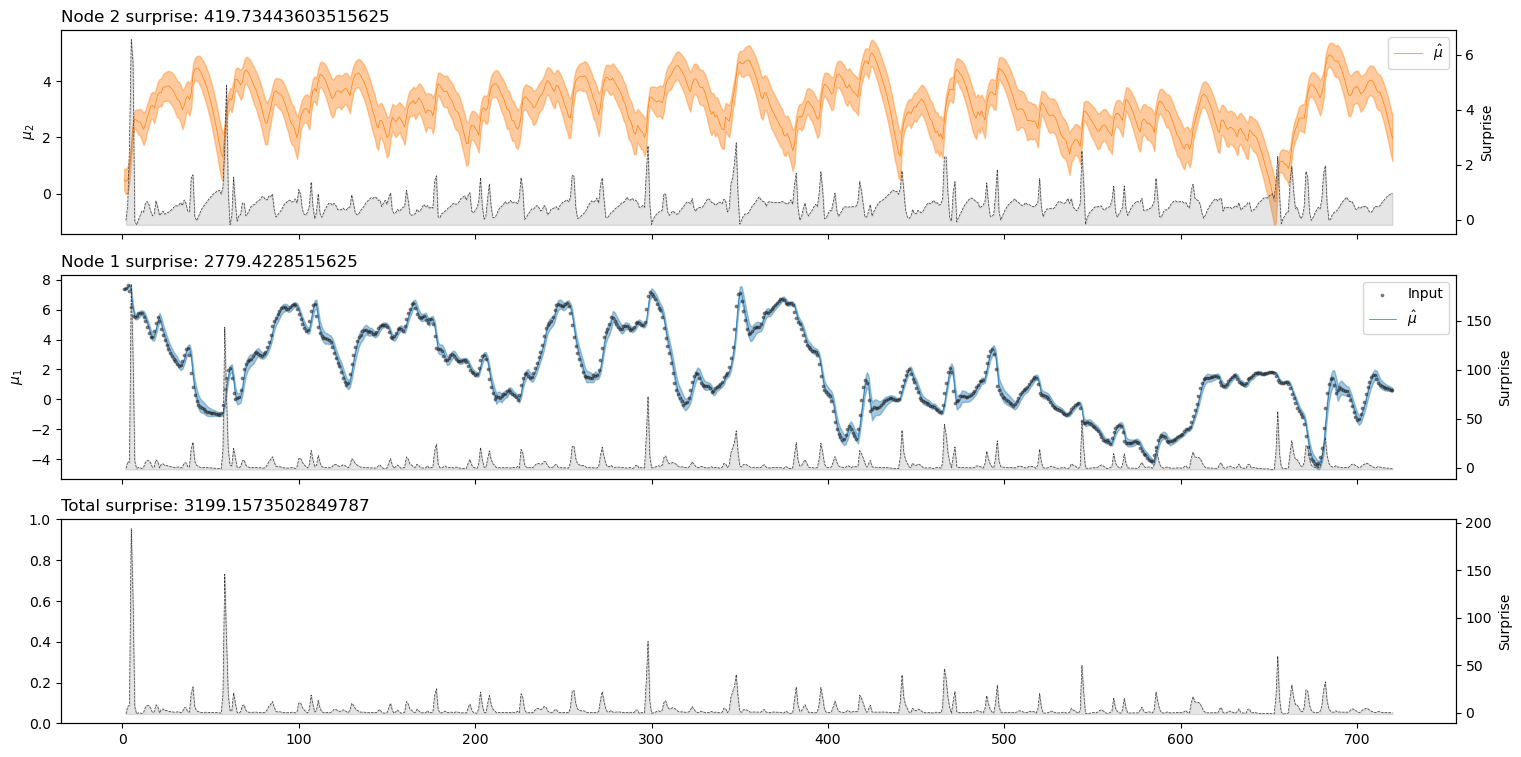

In [51]:
# Load time series example data
timeserie = aarhus_weather_df["t2m"][:24*30]

# This is where we define all the model parameters - You can control the value of
# different variables at different levels using the corresponding dictionary.
hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": timeserie[0], "2": .5},
    initial_pi={"1": 31e4, "2": 1e1},
    omega={"1":-6.0, "2": -3.0},
)

# add new observations
hgf.input_data(input_data=timeserie)

# visualization of the belief trajectories
hgf.plot_trajectories();

### Creating an agent 

Workflow of creating an agent with a response function:

- Get the trajectories from the hgf with the function `to_pandas()`.
- Determine which states could be interesting to work with, and how they might influence decision making.
- Set up a function taking the rows of the trajectories as inputs and return an action based on some comuptations you choose.

The most important state trajecotories of the HGF. 

- posterior mean: $\mu$
- posterior precision: $\pi$
- prediction mean: $\hat{\mu}$
- prediction precision:  $\hat{\pi}$
- surprise

In [57]:
# get beliefs trajectories from the agent
trajectories = hgf.to_pandas()
trajectories = trajectories.drop(["time", "time_steps"], axis=1)
trajectories.head()

,observation,x_1_mu,x_1_pi,x_1_muhat,x_1_pihat,x_1_surprise,x_2_mu,x_2_pi,x_2_muhat,x_2_pihat,x_2_surprise,surprise
0,7.387,7.387000,10244.500000,7.387000,244.498947,NaN,0.427208,6.699697,0.500000,6.676144,NaN,NaN
1,7.472,7.469874,10256.577148,7.387000,256.576599,-0.947414,0.492652,5.863727,0.427208,5.023926,-0.030151,-0.977565
2,7.635,7.631119,10240.712891,7.469874,240.711533,6.035478,0.837745,7.473376,0.492652,4.538707,0.535200,6.570678
3,7.224,7.230870,10171.632812,7.631119,171.632126,5.453125,1.541305,18.525702,0.837745,5.446760,2.658163,8.111288
4,6.147,6.156204,10085.648438,7.230870,85.647461,187.365509,2.380432,57.856964,1.541305,9.637056,6.552755,193.918259


In [58]:
# join the beliefs and observation
trajectories = pd.concat([aarhus_weather_df, trajectories], axis=1)
trajectories["time"] = pd.to_datetime(trajectories["time"])
trajectories.head()

,time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot,observation,...,x_1_pi,x_1_muhat,x_1_pihat,x_1_surprise,x_2_mu,x_2_pi,x_2_muhat,x_2_pihat,x_2_surprise,surprise
0,2019-01-01 00:00:00,7.387,0.124,0.0,0.0,1.249,0.0,0.0,0.931,7.387,...,10244.500000,7.387000,244.498947,NaN,0.427208,6.699697,0.500000,6.676144,NaN,NaN
1,2019-01-01 01:00:00,7.472,0.200,0.0,0.0,1.247,0.0,0.0,0.865,7.472,...,10256.577148,7.387000,256.576599,-0.947414,0.492652,5.863727,0.427208,5.023926,-0.030151,-0.977565
2,2019-01-01 02:00:00,7.635,0.196,0.0,0.0,1.244,0.0,0.0,0.701,7.635,...,10240.712891,7.469874,240.711533,6.035478,0.837745,7.473376,0.492652,4.538707,0.535200,6.570678
3,2019-01-01 03:00:00,7.224,0.061,0.0,0.0,1.245,0.0,0.0,0.387,7.224,...,10171.632812,7.631119,171.632126,5.453125,1.541305,18.525702,0.837745,5.446760,2.658163,8.111288
4,2019-01-01 04:00:00,6.147,0.018,0.0,0.0,1.250,0.0,0.0,0.128,6.147,...,10085.648438,7.230870,85.647461,187.365509,2.380432,57.856964,1.541305,9.637056,6.552755,193.918259


In [65]:
# aggregate over one day
trajectories.groupby(trajectories["time"].dt.date, as_index=False)[["x_1_mu", "prectotland"]].sum()

,x_1_mu,prectotland
0,131.603577,0.714
1,39.268307,0.023
2,11.851880,0.042
3,108.671432,0.113
4,118.146599,0.057
...,...,...
360,0.000000,0.122
361,0.000000,0.065
362,0.000000,0.104
363,0.000000,0.783


In [ ]:
# 1 - create a decision function: based on the beliefs over the previous hour/day/week, decide e.g. if the agent should carry an umbrella

In [ ]:
# 2 - create an outcome function: based on the parameters that were recorded in the main data frame, what was the outcome (e.g. raining or not?)

In [ ]:
# 3 - compute the surprise: how surprised are the agents if it was raining and no umbrella etc...